In [1]:
import pandas as pd
import scanpy as sc
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [4]:
adata2 = sc.read_h5ad('scRNAseq_pancan_normalized.h5ad') #Contains all samples
adata2

AnnData object with n_obs × n_vars = 1273816 × 14090
    obs: 'SampleID', 'DataID', 'Age', 'Sex', 'Treatment', 'Organ', 'Cancertype', 'tissue_type', 'DataSampleID', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch'
    var: 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1'

In [9]:
adata2.obs['celltype'] = adata2.obs['celltype'].cat.add_categories('Unknown')
adata2.obs['celltype']= adata2.obs['celltype'].fillna('Unknown')

In [10]:
adata = adata2[((adata2.obs['DataID']=='EGAD00001008030')|(adata2.obs['celltype']!='Unknown')),:].copy()
adata

AnnData object with n_obs × n_vars = 798239 × 14090
    obs: 'SampleID', 'DataID', 'Age', 'Sex', 'Treatment', 'Organ', 'Cancertype', 'tissue_type', 'DataSampleID', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch'
    var: 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1'

# scVI

In [12]:
sc.pp.highly_variable_genes(adata, flavor = 'seurat_v3', n_top_genes=2000, #layer = "counts", 
                            subset = False, inplace=True)

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [14]:
import scvi
scvi.model.SCVI.setup_anndata(adata,  batch_key='DataSampleID')#layer = 'counts',
vae = scvi.model.SCVI(adata)

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/abc.py:98: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
/home

In [15]:
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/abc.py:98: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/10:  10%|█         | 1/10 [04:05<36:49, 245.45s/it, v_num=1, train_loss_step=3.91e+3, train_loss_epoch=4.13e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 10/10: 100%|██████████| 10/10 [39:24<00:00, 234.57s/it, v_num=1, train_loss_step=4.33e+3, train_loss_epoch=3.98e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [39:24<00:00, 236.42s/it, v_num=1, train_loss_step=4.33e+3, train_loss_epoch=3.98e+3]


In [17]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = vae.get_latent_representation(adata)

In [18]:
sc.pp.neighbors(adata, use_rep = SCVI_LATENT_KEY)
sc.tl.umap(adata)

# scANVI

In [20]:
lvae = scvi.model.SCANVI.from_scvi_model(vae, adata = adata, unlabeled_category = 'Unknown',
                                        labels_key = 'celltype')

lvae.train(max_epochs=20, n_samples_per_label=100)

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


INFO     Training for 20 epochs.                                                                                   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/20:   0%|          | 0/20 [00:00<?, ?it/s]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 2/20:   5%|▌         | 1/20 [04:44<1:30:04, 284.46s/it, v_num=1, train_loss_step=4.14e+3, train_loss_epoch=4.04e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 20/20: 100%|██████████| 20/20 [1:43:00<00:00, 320.36s/it, v_num=1, train_loss_step=4.01e+3, train_loss_epoch=4.02e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [1:43:00<00:00, 309.04s/it, v_num=1, train_loss_step=4.01e+3, train_loss_epoch=4.02e+3]


In [21]:
adata.obs['Celltype1'] = lvae.predict(adata)
adata.obs

,SampleID,DataID,Age,Sex,Treatment,Organ,Cancertype,tissue_type,DataSampleID,celltype,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,batch,_scvi_batch,_scvi_labels,Celltype1
EGAD00001008030_PD43948_Blood_5739STDY7958790_AAGTCTGTCGGATGGA-1-1,PD43948_Blood,EGAD00001008030,75.0,Female,0,Blood,ccRCC,-,EGAD00001008030_PD43948_Blood,Unknown,853.0,2624.0,191.0,7.278963,853.0,1,28,6,Plasma
EGAD00001008030_PD43948_Blood_5739STDY7958790_ACACCCTGTGTGAAAT-1-1,PD43948_Blood,EGAD00001008030,75.0,Female,0,Blood,ccRCC,-,EGAD00001008030_PD43948_Blood,Unknown,638.0,4531.0,124.0,2.736703,638.0,1,28,6,Plasma
EGAD00001008030_PD43948_Blood_5739STDY7958790_ACATGGTTCAGTTTGG-1-1,PD43948_Blood,EGAD00001008030,75.0,Female,0,Blood,ccRCC,-,EGAD00001008030_PD43948_Blood,Unknown,1284.0,2829.0,252.0,8.907741,1284.0,1,28,6,Plasma
EGAD00001008030_PD43948_Blood_5739STDY7958790_AGAGTGGGTTTAGGAA-1-1,PD43948_Blood,EGAD00001008030,75.0,Female,0,Blood,ccRCC,-,EGAD00001008030_PD43948_Blood,Unknown,947.0,4141.0,128.0,3.091041,947.0,1,28,6,Plasma
EGAD00001008030_PD43948_Blood_5739STDY7958790_AGATTGCAGGGCTTCC-1-1,PD43948_Blood,EGAD00001008030,75.0,Female,0,Blood,ccRCC,-,EGAD00001008030_PD43948_Blood,Unknown,865.0,4337.0,178.0,4.104220,865.0,1,28,6,Plasma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
phs001818.v1.p1_6709t1_TTTGCGCTCAACACAC-1-1,6709t1,phs001818.v1.p1,67.0,Female,0,Gastric,Gastric intestinal metaplasia,Tumor,phs001818.v1.p1_6709t1,Myeloid,530.0,1054.0,41.0,3.889943,530.0,1,220,4,Myeloid
phs001818.v1.p1_6709t1_TTTGGTTCACGGATAG-1-1,6709t1,phs001818.v1.p1,67.0,Female,0,Gastric,Gastric intestinal metaplasia,Tumor,phs001818.v1.p1_6709t1,Fibroblast,794.0,2239.0,35.0,1.563198,794.0,1,220,2,Fibroblast
phs001818.v1.p1_6709t1_TTTGGTTTCTTGCATT-1-1,6709t1,phs001818.v1.p1,67.0,Female,0,Gastric,Gastric intestinal metaplasia,Tumor,phs001818.v1.p1_6709t1,Myeloid,446.0,1013.0,27.0,2.665350,446.0,1,220,4,Myeloid
phs001818.v1.p1_6709t1_TTTGTCACATCCCACT-1-1,6709t1,phs001818.v1.p1,67.0,Female,0,Gastric,Gastric intestinal metaplasia,Tumor,phs001818.v1.p1_6709t1,Lymphocyte,499.0,981.0,14.0,1.427115,499.0,1,220,3,Lymphocyte


In [22]:
adata.obsm["X_scANVI"] = lvae.get_latent_representation()

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotti

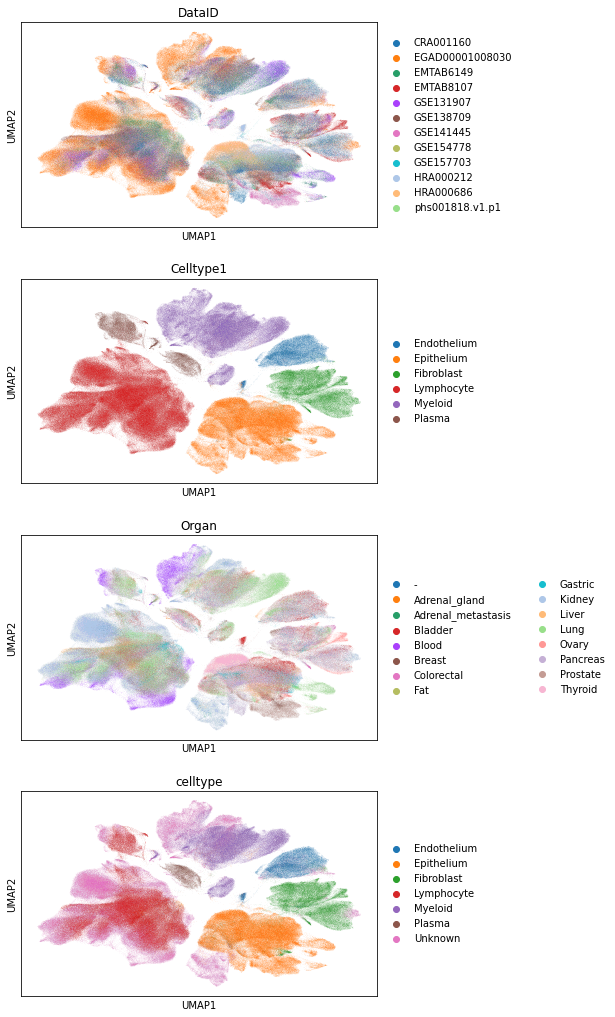

In [23]:
sc.pl.umap(
    adata, 
    color=['DataID',"Celltype1",'Organ',"celltype"], 
    ncols=1, 
    #legend_loc="on data",
    #legend_fontsize = "xx-small"
)

In [24]:
adata3 = adata[adata.obs['DataID']=='EGAD00001008030',:].copy()
adata3

AnnData object with n_obs × n_vars = 261318 × 14090
    obs: 'SampleID', 'DataID', 'Age', 'Sex', 'Treatment', 'Organ', 'Cancertype', 'tissue_type', 'DataSampleID', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', '_scvi_batch', '_scvi_labels', 'Celltype1'
    var: 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'DataID_colors', 'Cancertype_colors', 'Organ_colors', 'celltype_colors', 'Celltype1_colors'
    obsm: 'X_scVI', 'X_umap', 'X_scANVI'
    obsp: 'distances', 'connectivities'

In [25]:
adata3.write_h5ad("EGAD00001008030_after_scANVI.h5ad")

# Cell typing

In [4]:
import scvi
scvi.model.SCVI.setup_anndata(adata3,  batch_key='DataSampleID')#layer = 'counts',
vae = scvi.model.SCVI(adata3)

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/abc.py:98: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
/home

In [5]:
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/31:   0%|          | 0/31 [00:00<?, ?it/s]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/abc.py:98: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/31:   3%|▎         | 1/31 [01:21<40:55, 81.86s/it, v_num=1, train_loss_step=3.68e+3, train_loss_epoch=4.16e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 3/31:   6%|▋         | 2/31 [02:40<38:34, 79.81s/it, v_num=1, train_loss_step=3.91e+3, train_loss_epoch=4e+3]   

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 4/31:  10%|▉         | 3/31 [03:58<36:53, 79.07s/it, v_num=1, train_loss_step=3.85e+3, train_loss_epoch=3.96e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 5/31:  13%|█▎        | 4/31 [05:17<35:32, 78.96s/it, v_num=1, train_loss_step=4.09e+3, train_loss_epoch=3.93e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 6/31:  16%|█▌        | 5/31 [06:35<34:07, 78.76s/it, v_num=1, train_loss_step=3.82e+3, train_loss_epoch=3.92e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 7/31:  19%|█▉        | 6/31 [07:57<33:19, 79.98s/it, v_num=1, train_loss_step=3.95e+3, train_loss_epoch=3.91e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 8/31:  23%|██▎       | 7/31 [09:19<32:11, 80.47s/it, v_num=1, train_loss_step=3.88e+3, train_loss_epoch=3.91e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 9/31:  26%|██▌       | 8/31 [10:37<30:30, 79.59s/it, v_num=1, train_loss_step=3.74e+3, train_loss_epoch=3.9e+3] 

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 10/31:  29%|██▉       | 9/31 [11:56<29:10, 79.55s/it, v_num=1, train_loss_step=3.79e+3, train_loss_epoch=3.9e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 11/31:  32%|███▏      | 10/31 [13:16<27:53, 79.68s/it, v_num=1, train_loss_step=3.95e+3, train_loss_epoch=3.9e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 12/31:  35%|███▌      | 11/31 [14:37<26:39, 80.00s/it, v_num=1, train_loss_step=3.99e+3, train_loss_epoch=3.89e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 13/31:  39%|███▊      | 12/31 [15:53<24:59, 78.94s/it, v_num=1, train_loss_step=3.78e+3, train_loss_epoch=3.89e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 14/31:  42%|████▏     | 13/31 [17:09<23:21, 77.83s/it, v_num=1, train_loss_step=3.8e+3, train_loss_epoch=3.89e+3] 

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 15/31:  45%|████▌     | 14/31 [18:25<21:57, 77.53s/it, v_num=1, train_loss_step=3.91e+3, train_loss_epoch=3.89e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 16/31:  48%|████▊     | 15/31 [19:43<20:39, 77.44s/it, v_num=1, train_loss_step=3.9e+3, train_loss_epoch=3.89e+3] 

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 17/31:  52%|█████▏    | 16/31 [20:58<19:12, 76.85s/it, v_num=1, train_loss_step=3.89e+3, train_loss_epoch=3.89e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 18/31:  55%|█████▍    | 17/31 [22:15<17:55, 76.80s/it, v_num=1, train_loss_step=3.71e+3, train_loss_epoch=3.89e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 19/31:  58%|█████▊    | 18/31 [23:30<16:31, 76.26s/it, v_num=1, train_loss_step=4.21e+3, train_loss_epoch=3.89e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 20/31:  61%|██████▏   | 19/31 [24:47<15:18, 76.55s/it, v_num=1, train_loss_step=4.03e+3, train_loss_epoch=3.89e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 21/31:  65%|██████▍   | 20/31 [26:03<13:59, 76.35s/it, v_num=1, train_loss_step=3.92e+3, train_loss_epoch=3.89e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 22/31:  68%|██████▊   | 21/31 [27:19<12:42, 76.29s/it, v_num=1, train_loss_step=3.8e+3, train_loss_epoch=3.89e+3] 

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 23/31:  71%|███████   | 22/31 [28:36<11:27, 76.42s/it, v_num=1, train_loss_step=3.81e+3, train_loss_epoch=3.89e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 24/31:  74%|███████▍  | 23/31 [29:52<10:11, 76.49s/it, v_num=1, train_loss_step=4.01e+3, train_loss_epoch=3.89e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 25/31:  77%|███████▋  | 24/31 [31:10<08:57, 76.73s/it, v_num=1, train_loss_step=3.84e+3, train_loss_epoch=3.88e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 26/31:  81%|████████  | 25/31 [32:26<07:40, 76.69s/it, v_num=1, train_loss_step=3.72e+3, train_loss_epoch=3.88e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 27/31:  84%|████████▍ | 26/31 [33:43<06:22, 76.56s/it, v_num=1, train_loss_step=3.92e+3, train_loss_epoch=3.88e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 28/31:  87%|████████▋ | 27/31 [34:58<05:04, 76.16s/it, v_num=1, train_loss_step=3.73e+3, train_loss_epoch=3.88e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 29/31:  90%|█████████ | 28/31 [36:16<03:50, 76.74s/it, v_num=1, train_loss_step=3.8e+3, train_loss_epoch=3.88e+3] 

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 30/31:  94%|█████████▎| 29/31 [37:32<02:33, 76.67s/it, v_num=1, train_loss_step=4.06e+3, train_loss_epoch=3.88e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 31/31:  97%|█████████▋| 30/31 [38:49<01:16, 76.66s/it, v_num=1, train_loss_step=3.81e+3, train_loss_epoch=3.88e+3]

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 31/31: 100%|██████████| 31/31 [40:05<00:00, 76.52s/it, v_num=1, train_loss_step=3.81e+3, train_loss_epoch=3.88e+3]

`Trainer.fit` stopped: `max_epochs=31` reached.


Epoch 31/31: 100%|██████████| 31/31 [40:05<00:00, 77.61s/it, v_num=1, train_loss_step=3.81e+3, train_loss_epoch=3.88e+3]


In [6]:
SCVI_LATENT_KEY = "X_scVI_2"
adata3.obsm[SCVI_LATENT_KEY] = vae.get_latent_representation(adata3)

In [7]:
sc.pp.neighbors(adata3, use_rep = SCVI_LATENT_KEY)
sc.tl.umap(adata3)
sc.tl.leiden(adata3, key_added="leiden_res0_2", resolution=0.2)

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Cat

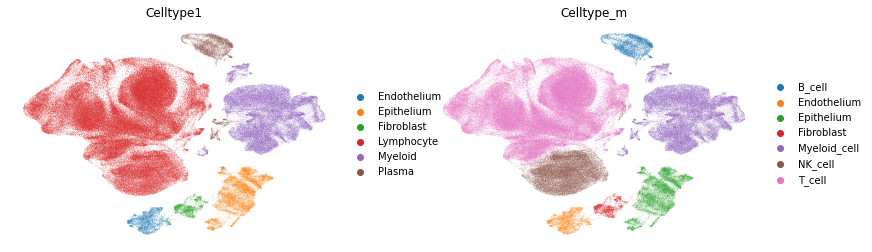

In [20]:
mapping ={
    '0': 'T_cell',
    '1': 'T_cell',
    '2': 'T_cell',
    '3': 'NK_cell',
    '4': 'Myeloid_cell',
    '5': 'Myeloid_cell',
    '6': 'Epithelium',
    '7': 'T_cell',
    '8': 'T_cell',
    '9': 'B_cell',
    '10': 'Endothelium',
    '11': 'Fibroblast',
    '12': 'Myeloid_cell',
    '13': 'Epithelium',
    '14': 'Myeloid_cell',
}
adata3.obs['Celltype_m'] = adata3.obs["leiden_res0_2"].map(mapping)
sc.pl.umap(adata3, color = ['Celltype1','Celltype_m'], frameon=False,ncols=2,vmax='p90',vmin='p5')#,'leiden'

In [40]:
adata3.write_h5ad("EGAD00001008030_secondscVI.h5ad",compression='gzip')

# LOY prediction

In [32]:
import joblib

In [33]:
rf_classifier_loaded = joblib.load('9YgenesonlyFinalnew_model.pkl')
rf_classifier_loaded

RandomForestClassifier(random_state=42)

In [34]:
Ychrgenes = ['DDX3Y', 'UTY', 'KDM5D', 'USP9Y', 'ZFY', 'RPS4Y1', 'TMSB4Y', 'EIF1AY', 'NLGN4Y']

In [36]:
#Obtain expression matrix
X_tumor = adata3[:, Ychrgenes].X.todense()
X_tumor = pd.DataFrame(X_tumor, columns=Ychrgenes, index=adata3.obs.index)
#Apply model
tumor_predictions = rf_classifier_loaded.predict(X_tumor)
#Get results
adata3.obs["RL_Prediction_Only9genes"]=tumor_predictions.copy()
adata3.obs["RL_Prediction_Only9genes"].value_counts()
adata3.obs['LOY'] = adata3.obs["RL_Prediction_Only9genes"].map({0: 'WTY_SCR', 1: 'LOY_SCR'})

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


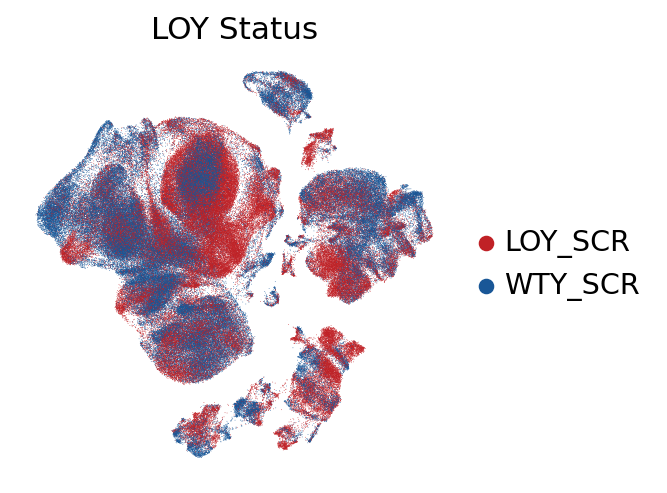

In [39]:
LOY_colors = {'LOY_SCR':'#C02126', 'WTY_SCR':'#195797'}
sc.set_figure_params(figsize=(3.5, 3.5))
sc.pl.umap(
    adata3,
    color=["LOY"],
    frameon=False,
    palette=LOY_colors,
    ncols=1,
    title='LOY Status',
)

In [35]:
adata3.write_h5ad("EGAD00001008030_secondscVI.h5ad.h5ad")

# Select Male 

In [42]:
adata3 = adata3[adata3.obs['Sex']=='Male',:].copy()
adata3

AnnData object with n_obs × n_vars = 161216 × 14090
    obs: 'SampleID', 'DataID', 'Age', 'Sex', 'Treatment', 'Organ', 'Cancertype', 'tissue_type', 'DataSampleID', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', '_scvi_batch', '_scvi_labels', 'Celltype1', 'leiden_res0_3', 'leiden_res0_5', 'leiden_res0_1', 'leiden_res0_2', 'Celltype_m', 'Sample_Celltype1', 'Tissue', 'PatientID', 'RL_Prediction_Only9genes', 'LOY'
    var: 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Cancertype_colors', 'Celltype1_colors', 'DataID_colors', 'Organ_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'hvg', 'neighbors', 'umap', 'leiden', 'leiden_res0_1_colors', 'leiden_res0_2_colors', 'leiden_res0_3_colors', 'leiden_res0_5_colors', 'Celltype_m_colors', 'LOY_colors'
    obsm: 'X_scANVI', 'X_scVI', 'X_uma

# LOY% plot

In [23]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
from matplotlib import colors
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import scipy

In [22]:
def get_LOY_fraction_plot(adata,ctlevel,Fig,n,m): 
    from scipy.stats import chi2_contingency

    #get count table
    data = pd.DataFrame(index = adata.obs[ctlevel].unique(), 
                        columns = ['LOY_SCR','WTY_SCR'])
    for loy in data.columns:
        data[loy]=pd.DataFrame(adata.obs.loc[adata.obs['LOY']==loy,ctlevel].value_counts()).iloc[:,0]     
    
    #get fraction table
    row_sum = data.sum(axis=1)
    data2 = data.div(row_sum,axis='rows')
    data2 = data2*100
    data2 = data2.fillna(0)
    #sort 
    data2.sort_values('LOY_SCR',inplace=True)
    print(data2)
    #plot
    fig, ax = plt.subplots(figsize=(n,m))
    data2.plot(kind='bar', stacked=True, color=['#c11c1d','#195697'],edgecolor='White',linewidth=1,ax=ax,width=0.9)
    labels = ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    labels = ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    plt.legend(loc = (1,0.5), fontsize = 7, frameon=False)
    plt.savefig(f'{Fig}_LOY_percentage.pdf',bbox_inches='tight',dpi=300,transparent=True)
    
    return data2
    

                              LOY_SCR     WTY_SCR
PD45814_Blood-Epithelium     0.000000  100.000000
PD47512_Tumor-Endothelium    0.000000  100.000000
PD45814_Blood-Endothelium    0.000000  100.000000
PD47512_Tumor-B_cell         0.754717   99.245283
PD47172_Tumor-B_cell         1.522843   98.477157
...                               ...         ...
PD44967_Tumor-Endothelium   66.666667   33.333333
PD47172_Tumor-Epithelium    85.714286   14.285714
PD44966_Tumor-Epithelium    96.078431    3.921569
PD43824_Tumor-Epithelium    97.857636    2.142364
PD47512_Tumor-Fibroblast   100.000000    0.000000

[85 rows x 2 columns]


/tmp/ipykernel_330434/2389328725.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  labels = ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


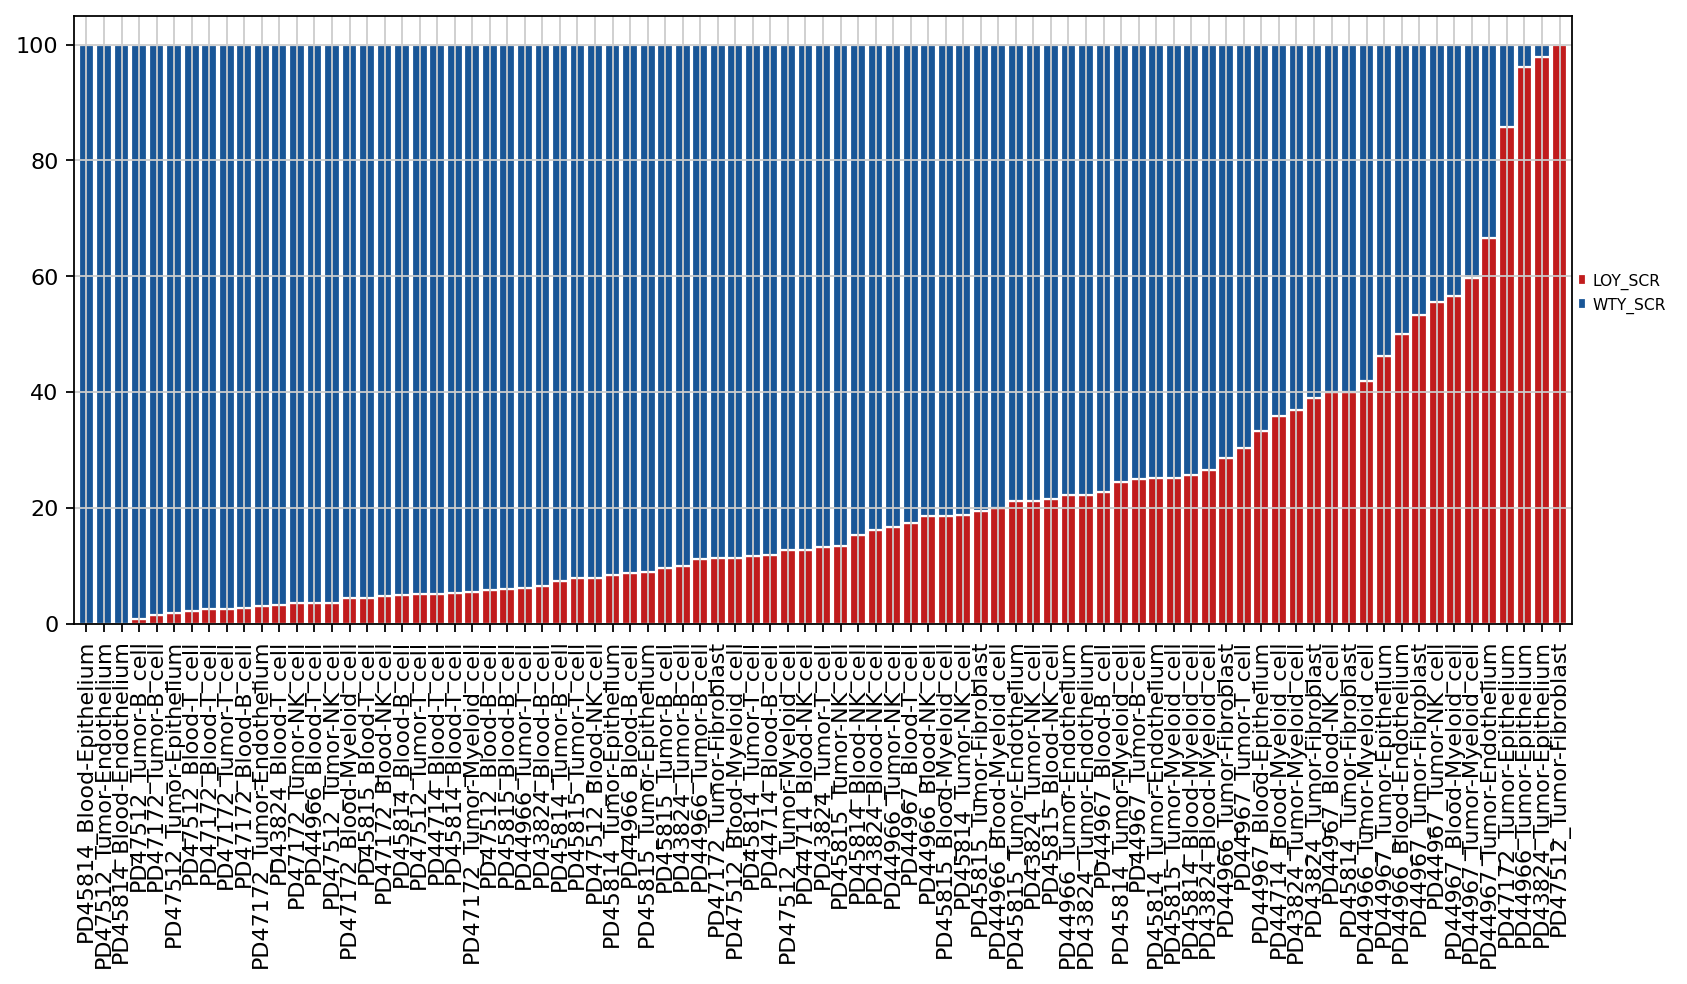

In [77]:
meta = adata3.obs[['SampleID', 'Tissue', 'PatientID', 'Sex', 'DataID', 'Cancertype']].drop_duplicates()
adata3.obs['Sample_Celltype1'] = adata3.obs['SampleID'].astype('str') + '-' + adata3.obs['Celltype_m'].astype('str')
data2 = get_LOY_fraction_plot(adata=adata3[adata3.obs['Tissue'].isin(['Tumor','Blood']),:], ctlevel='Sample_Celltype1',Fig='EGAD00001008030',n=12,m=5)

In [80]:
#Copy meta data
data2['SampleID'] = [ind.split('-')[0] for ind in data2.index]
data2['Celltype'] = [ind.split('-')[1] for ind in data2.index]
data2['Patient'] = data2['SampleID'].map(dict(zip(meta['SampleID'],meta['PatientID'])))
data2['tissue'] = data2['SampleID'].map(dict(zip(meta['SampleID'],meta['Tissue'])))
data2['Tissue_celltype'] = data2['tissue'].astype('str') +'-'+data2['Celltype'].astype('str')
#Re-shape table
data = data2.pivot_table(index=['Patient'], columns='Tissue_celltype', values='LOY_SCR')
data

Tissue_celltype,Blood-B_cell,Blood-Endothelium,Blood-Epithelium,Blood-Myeloid_cell,Blood-NK_cell,Blood-T_cell,Tumor-B_cell,Tumor-Endothelium,Tumor-Epithelium,Tumor-Fibroblast,Tumor-Myeloid_cell,Tumor-NK_cell,Tumor-T_cell
Patient,,,,,,,,,,,,,
PD43824,6.487342,NaN,NaN,26.467662,16.256158,3.259727,9.878683,22.285714,97.857636,38.983051,36.960029,21.209571,13.203051
PD44714,11.834320,NaN,NaN,35.916135,12.807882,5.203938,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PD44966,8.785249,50.0,NaN,20.052693,18.564177,3.586957,11.111111,22.222222,96.078431,28.571429,41.988950,16.774194,6.178010
PD44967,22.660099,NaN,33.333333,56.621188,39.946140,17.358171,25.000000,66.666667,46.226415,53.333333,59.615385,55.555556,30.270270
PD45814,4.918033,0.0,0.000000,25.742574,15.384615,5.363985,7.307692,25.161290,8.366534,40.000000,24.498367,18.829911,11.627331
PD45815,5.945122,NaN,NaN,18.613414,21.601942,4.419370,9.644670,21.160410,8.945935,19.402985,25.183512,13.351835,7.812500
PD47172,2.654867,NaN,NaN,4.367816,4.779412,2.510608,1.522843,3.048376,85.714286,11.315166,5.440696,3.518268,2.523659
PD47512,5.797101,NaN,NaN,11.376872,7.954545,2.248006,0.754717,0.000000,1.927195,100.000000,12.666921,3.612903,5.140759


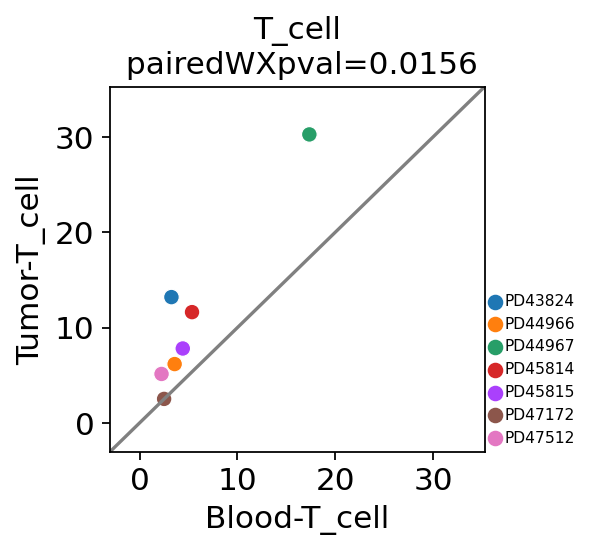

In [89]:
#Fig5a
c = 'T_cell'
X = 'Blood-'+c
Y = "Tumor-"+c
sub_data = data.loc[:,[X, Y]].copy()
sub_data = sub_data.dropna()
fig, ax = plt.subplots(figsize=(3, 3))
p = sns.scatterplot(
                x=X,
                y=Y,
                s=50,
                hue='Patient',
                #cmap='RdYlBu_r',
                data=sub_data,
    )
ax.set(ylim=(-3,max(max(data[X]),max(data[Y]))+5))
ax.set(xlim=(-3,max(max(data[X]),max(data[Y]))+5))
ax.axline((0, 0), slope=1,color='gray')
ax.set_title(c+'\n pairedWXpval='+'%.4f'%scipy.stats.wilcoxon(sub_data[X],sub_data[Y])[1])
plt.grid(False)
plt.legend(loc = (1,0), fontsize = 7, frameon=False)
plt.savefig('EGAD00001008030_'+c+'tumor&blood_scatter.pdf', dpi=300, bbox_inches='tight')

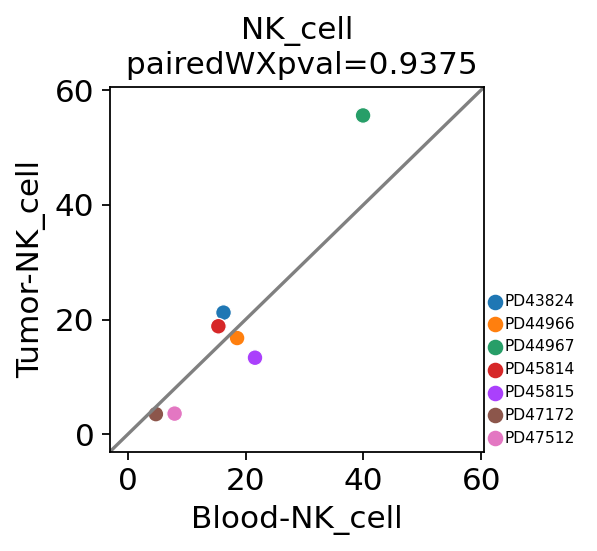

In [90]:
#Fig5a
c = 'NK_cell'
X = 'Blood-'+c
Y = "Tumor-"+c
sub_data = data.loc[:,[X, Y]].copy()
sub_data = sub_data.dropna()
fig, ax = plt.subplots(figsize=(3, 3))
p = sns.scatterplot(
                x=X,
                y=Y,
                s=50,
                hue='Patient',
                #cmap='RdYlBu_r',
                data=sub_data,
    )
ax.set(ylim=(-3,max(max(data[X]),max(data[Y]))+5))
ax.set(xlim=(-3,max(max(data[X]),max(data[Y]))+5))
ax.axline((0, 0), slope=1,color='gray')
ax.set_title(c+'\n pairedWXpval='+'%.4f'%scipy.stats.wilcoxon(sub_data[X],sub_data[Y])[1])
plt.grid(False)
plt.legend(loc = (1,0), fontsize = 7, frameon=False)
plt.savefig('EGAD00001008030_'+c+'tumor&blood_scatter.pdf', dpi=300, bbox_inches='tight')

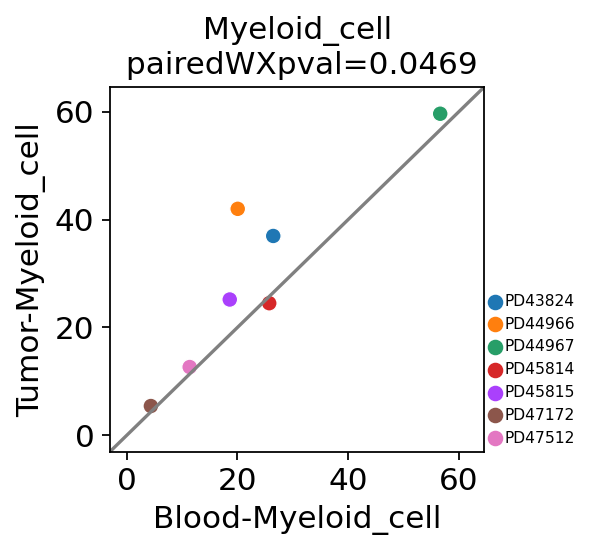

In [91]:
#Fig5a
c = 'Myeloid_cell'
X = 'Blood-'+c
Y = "Tumor-"+c
sub_data = data.loc[:,[X, Y]].copy()
sub_data = sub_data.dropna()
fig, ax = plt.subplots(figsize=(3, 3))
p = sns.scatterplot(
                x=X,
                y=Y,
                s=50,
                hue='Patient',
                #cmap='RdYlBu_r',
                data=sub_data,
    )
ax.set(ylim=(-3,max(max(data[X]),max(data[Y]))+5))
ax.set(xlim=(-3,max(max(data[X]),max(data[Y]))+5))
ax.axline((0, 0), slope=1,color='gray')
ax.set_title(c+'\n pairedWXpval='+'%.4f'%scipy.stats.wilcoxon(sub_data[X],sub_data[Y])[1])
plt.grid(False)
plt.legend(loc = (1,0), fontsize = 7, frameon=False)
plt.savefig('EGAD00001008030_'+c+'tumor&blood_scatter.pdf', dpi=300, bbox_inches='tight')

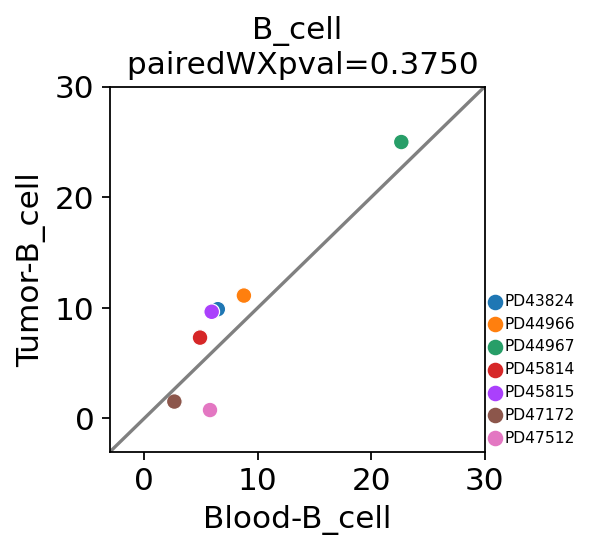

In [92]:
#Fig5a
c = 'B_cell'
X = 'Blood-'+c
Y = "Tumor-"+c
sub_data = data.loc[:,[X, Y]].copy()
sub_data = sub_data.dropna()
fig, ax = plt.subplots(figsize=(3, 3))
p = sns.scatterplot(
                x=X,
                y=Y,
                s=50,
                hue='Patient',
                #cmap='RdYlBu_r',
                data=sub_data,
    )
ax.set(ylim=(-3,max(max(data[X]),max(data[Y]))+5))
ax.set(xlim=(-3,max(max(data[X]),max(data[Y]))+5))
ax.axline((0, 0), slope=1,color='gray')
ax.set_title(c+'\n pairedWXpval='+'%.4f'%scipy.stats.wilcoxon(sub_data[X],sub_data[Y])[1])
plt.grid(False)
plt.legend(loc = (1,0), fontsize = 7, frameon=False)
plt.savefig('EGAD00001008030_'+c+'tumor&blood_scatter.pdf', dpi=300, bbox_inches='tight')

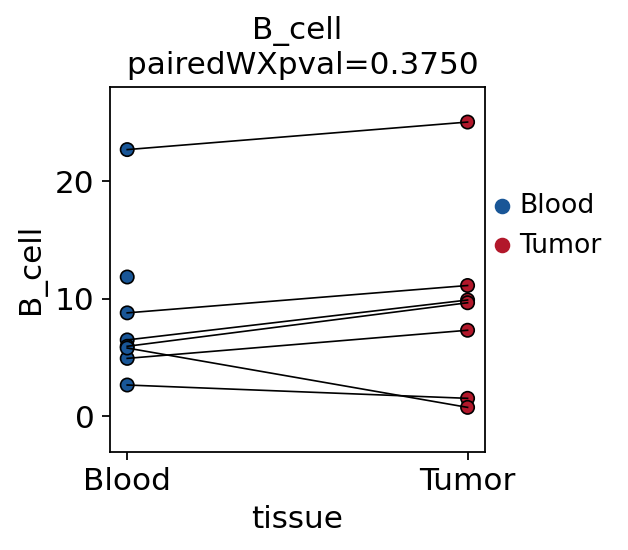

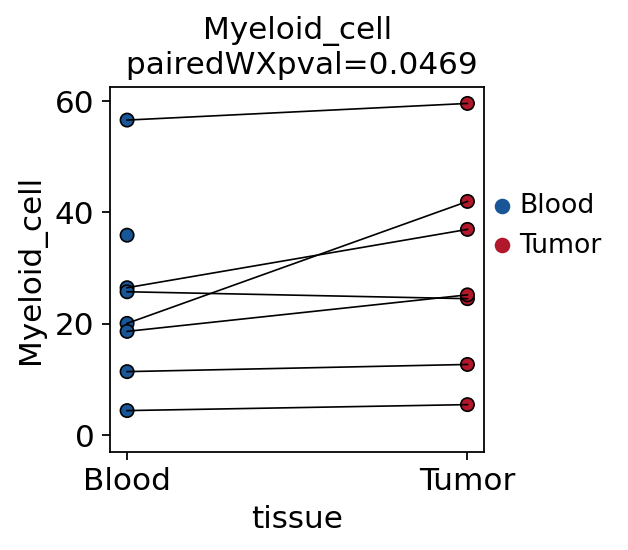

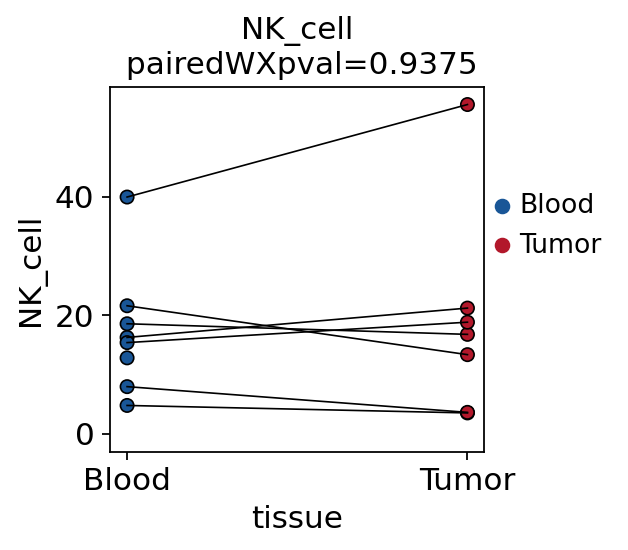

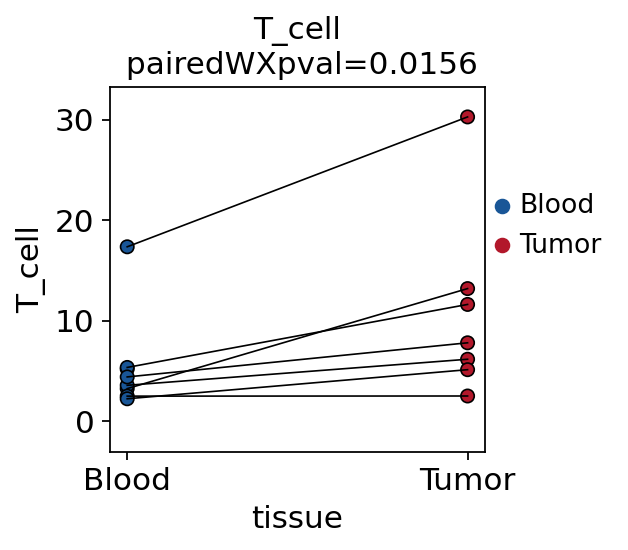

In [87]:
#Paired dot plot in Fig5a
data2 = data2.pivot_table(index=['SampleID'], columns='Celltype', values='LOY_SCR')
data2['tissue'] = [ind.split('_')[-1] for ind in data2.index]
data2['Patient'] = [ind.split('_')[0] for ind in data2.index]

CTs = ['B_cell', 'Myeloid_cell', 'NK_cell', 'T_cell']
for CT in CTs:   
    data3 = data2.pivot_table(index=['Patient'], columns='tissue', values=CT)
    data3 = data3.dropna()
    fig, ax = plt.subplots(figsize=(3, 3))
    # Plotting the lines
    ax.plot( [0,1], [data3['Blood'], data3['Tumor']], c='k',linewidth=.75)
    # Draw the dots
    sns.scatterplot(data=data2, x="tissue", y=CT, hue='tissue', palette = {'Tumor':"#B2182B",'Blood':"#195697"},
                  edgecolor="black", linewidth=.75,ax=ax)
    
    plt.grid(False)
    ax.set(ylim=(-3,max(data2[CT]+3)))
    ax.set_title(CT+'\n pairedWXpval='+'%.4f'%scipy.stats.wilcoxon(data3['Blood'],data3['Tumor'])[1])
    plt.legend(loc = (1,0.5), fontsize = 12, frameon=False)
    plt.savefig('EGAD00001008030_'+CT+'blood&tumor_paired_dot.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    